In [4]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import math
import numpy as np
from statsmodels.tsa.arima_model import ARMA

In [5]:
base_currency = 'BTC'
#argument needs to be in the form of a string
def get450Day(ticker):
        ''' Acquire historical prices from CRYPTOCOMPARE '''
        url='https://min-api.cryptocompare.com/data/histoday'
        #will return a str
#prices from last 200 days
        parameters= {'fsym':ticker, 'tsym': base_currency, 'e': 'Bittrex', 'aggregate':1,'limit':450}
        
        r=requests.get(url,parameters)
        #handle this error in the calling class
        j_obj=r.json()
        if j_obj['Response']=='Error':
            print(j_obj)
            #print("fetch didn't work")
            raise RuntimeError
        raw_time=j_obj['Data']
        df=pd.DataFrame.from_dict(raw_time)
        df['time']=df['time'].apply(lambda x: datetime.datetime.fromtimestamp(x))
        df.index=pd.to_datetime(df.time)
        return(df)

In [6]:
mro_df=get450Day('XMR')
mro_df['returns']=mro_df['low'].pct_change()
autocorrelation=mro_df['returns'].autocorr()

Nominal prices likely follow a random walk. The one day differentials will be white noise. A random walk is additive.
$P_{t}=\mu + P_{t-1} +\epsilon$.
We can choose to fit an ARMA model and check for the coefficient: If testing for price, its needs to be near 1, if fitting the model on differences, including returns, look for a 0 coefficient.

Apply an augmented Dickey Fuller to determine whether there are any unit roots in the series, ie any departures from stationarity. The null hypothesis is the presence of a unit root. P-values below a selected threshold will allow us to reject the null and conculde stationarity. The adfuller() function does not take any parameters... the defaults are the most practical. You cannot enter a lag... that is done automatically across several lags.

In [19]:
results=adfuller(mro_df['low'])
print('the ADF p-value is {} on the prices of MRO as measured by the low'.format(results[1]))
results_r=adfuller(mro_df['returns'][1:])
print('the ADF p-value is {} on the returns of MRO as measured by the low'.format(results_r[1]))

the ADF p-value is 0.39728472520218294 on the prices of MRO as measured by the low
the ADF p-value is 0.0 on the returns of MRO as measured by the low


Very high p-value... cannot reject the null that there is a unit root in the series and therefore we can conclude that the untreated series is not stationary. If we prematurely apply an AR1 model we get the below. Returns are white noise and are stationary.

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf
mro_diff1=mro_df['low'].diff()
mro_diff1=mro_diff1.dropna()

In [9]:
mro_diff1.head()

time
2017-01-27 19:00:00    0.00050
2017-01-28 19:00:00    0.00052
2017-01-29 19:00:00    0.00000
2017-01-30 19:00:00   -0.00022
2017-01-31 19:00:00   -0.00017
Name: low, dtype: float64

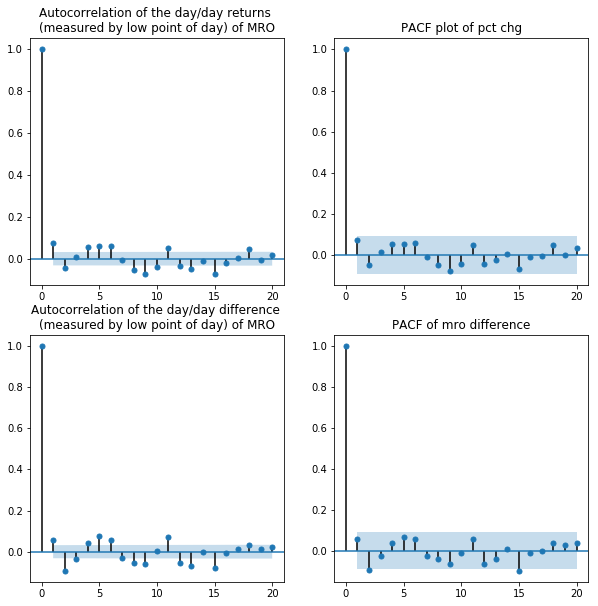

In [24]:
mro_diff=mro_df['returns'].dropna()
plt.close()

fig, axes = plt.subplots(2,2)

#fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
#fig.set_figure()
fig.set_figwidth(10)
fig.set_figheight(10)

plot_acf(mro_diff,lags=20,alpha=0.5, ax=axes[0,0])
axes[0,0].set_title('Autocorrelation of the day/day returns \n(measured by low point of day) of MRO')

plot_pacf(mro_diff,lags=20, ax=axes[0,1])
axes[0,1].set_title('PACF plot of pct chg')

plot_acf(mro_diff1,lags=20,alpha=0.5, ax=axes[1,0])
axes[1,0].set_title('Autocorrelation of the day/day difference \n(measured by low point of day) of MRO')

plot_pacf(mro_diff1,lags=20, ax=axes[1,1])
axes[1,1].set_title('PACF of mro difference')

plt.show()

Due to some significant autorcorrelation at several steps, we expect a lack of stationarity. Observable above is the oscillating nature of the autocorrelation. This is not correct! We can simulate stationary data, like white noise and observe some quasi significant autocorrelations... they are not reliable. Autocorrelation doesn't cause non-stationarity. Non-stationarity doesn't require autocorrelation. 

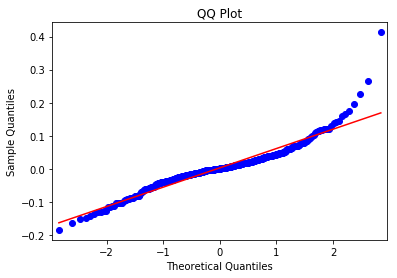

In [34]:
plt.close()
sm.qqplot(mro_df['returns'][1:], line='s')
plt.title('QQ Plot') 
plt.show()

Compare this autororrelation plot to one fit onto pure white noise, which is stationary.

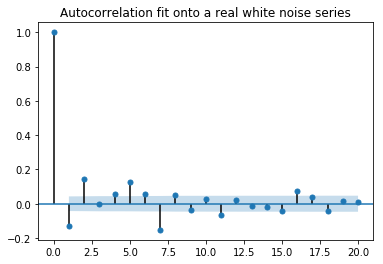

In [7]:
plt.close()
norms=np.random.normal(loc=.001,scale=.01,size=250)
plot_acf(norms,lags=20,alpha=0.5)
plt.title('Autocorrelation fit onto a real white noise series')
plt.show()

### Estimating an AR(1) model

                              ARMA Model Results                              
Dep. Variable:                    low   No. Observations:                  451
Model:                     ARMA(1, 0)   Log Likelihood                2446.714
Method:                       css-mle   S.D. of innovations              0.001
Date:                Fri, 20 Apr 2018   AIC                          -4887.428
Time:                        23:41:04   BIC                          -4875.094
Sample:                    01-25-2017   HQIC                         -4882.567
                         - 04-20-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0196      0.003      7.229      0.000       0.014       0.025
ar.L1.low      0.9835      0.009    114.643      0.000       0.967       1.000
                                    Roots           

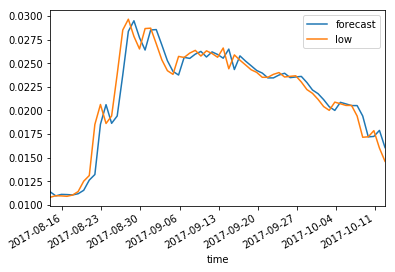

In [14]:
#fit the model on the untreated prices
mod=ARMA(mro_df['low'],order=(1,0))
res=mod.fit()
print(res.summary())
res.plot_predict(start=200, end=260)
plt.show()

Note that the coeficcent is high, but not over 1. This implies a trending or momentum behavior. Additionally, being so close to 1 implies a random walk behavior.

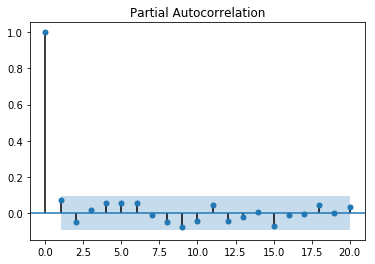

In [36]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(mro_df['returns'][1:],lags=20)
plt.show()

Looks like there are no significant lags, which invalidates any AR models.

We are clueless which model is best given that there may be some slight autocorrelation that seems to hang and suggests that trended walks are followed by strong mean reversion. We will fit several AR models - from 1 to 6, then plot the AIC, BIC - these are measures of goodness of fit.

In [16]:
results=[]
for i in np.arange(1,7,1):
    mod=ARMA(mro_df['low'],order=(i,0))
    res=mod.fit()
    results.append((res.aic, res.bic))

bic=[i[1] for i in results]
aic=[i[0] for i in results]

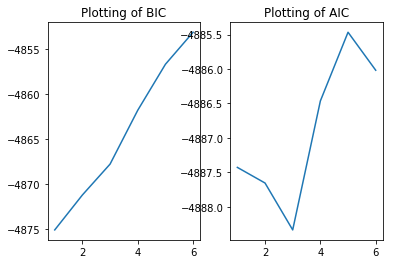

In [17]:
plt.subplot(1,2,1)
plt.plot(np.arange(1,7,1),bic)
plt.title('Plotting of BIC')

plt.subplot(1,2,2)
plt.plot(np.arange(1,7,1),aic)
plt.title('Plotting of AIC')
plt.show()

### AR Model Application to MRO
Although there is a maximum for the AIC plot, the difference is negligable. The videos only make use of the BIC statistic. We'll plot an AR5 model and plot the distribution of the error terms. Recall that the ADF test could not disprove a unit root to the series, and so it should be treated.

In [24]:
mod=ARMA(mro_df['returns'][1:],order=(5,0))
res=mod.fit()

In [25]:
results=[]
for i in np.arange(1,7,1):
    mod=ARMA(mro_df['returns'][1:],order=(i,0))
    res=mod.fit()
    results.append((res.aic, res.bic))

bic_r=[i[1] for i in results]
aic_r=[i[0] for i in results]

In [1]:
plt.subplot(1,2,1)
plt.plot(np.arange(1,7,1),bic_r)
plt.title('BIC Plot')

plt.subplot(1,2,2)
plt.plot(np.arange(1,7,1),aic_r)
plt.title('AIC Plot')
plt.show()

NameError: name 'plt' is not defined

It looks like this model is prone to overfitting.

In [28]:
mod=ARMA(mro_df['returns'][1:],order=(5,0))
res=mod.fit()
print(res.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                  450
Model:                     ARMA(5, 0)   Log Likelihood                 643.381
Method:                       css-mle   S.D. of innovations              0.058
Date:                Sat, 21 Apr 2018   AIC                          -1272.762
Time:                        00:08:29   BIC                          -1243.997
Sample:                    01-26-2017   HQIC                         -1261.425
                         - 04-20-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0035      0.003      1.107      0.269      -0.003       0.010
ar.L1.returns     0.0741      0.047      1.575      0.116      -0.018       0.166
ar.L2.returns    -0.0451      0.047     

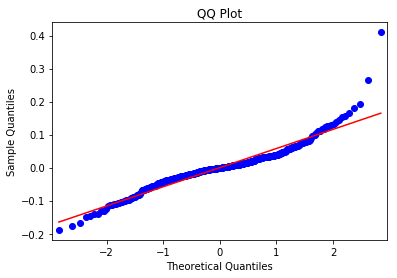

In [33]:
plt.close()
sm.qqplot(res.resid, line='s')
plt.title('QQ Plot') 
plt.show()

To only view the parameters of the fitted AR model, can call {{res.params}}

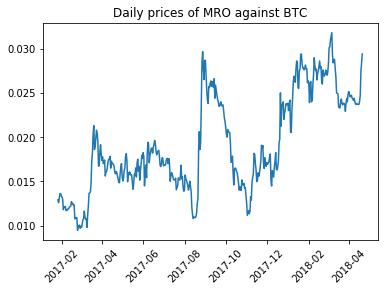

In [9]:
plt.close()
plt.plot(mro_df['low'])
plt.title('Daily prices of MRO against BTC')
#plt.xticks(mro_df['returns'].index.values)
plt.xticks(rotation=45)
plt.show()

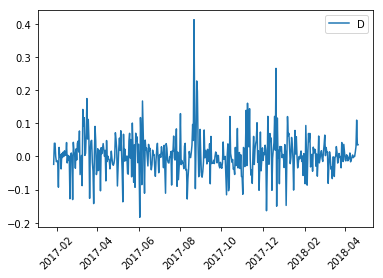

In [11]:
plt.close()
plt.plot(mro_df['returns'])
plt.legend('Daily Returns of MRO')
#plt.xticks(mro_df['returns'].index.values)
plt.xticks(rotation=45)
plt.show()

In [ ]:
plot_acf(mro_df['returns'][1:],lags=20,alpha=.05)
plt.title('Autocorrelation on daily returns - low of the day as unit')
plt.show()

On the above we see the inclusion of confidence intervals around the autocorrelation calculations. Confidence intervals are the bands above and below zero where a statistically significant divergence from 0 cannot be claimed at 95% confidence. This mechanism makes use of the standard normal distribution and calculates the variance with 0 at the mean - 95% of the spread of distribution is contained within 1.96 times the standard deviation. The standard deviation is calculated as 1/sqrt(N)... N = # of observations. What would be interesting is to extract the confidence bands from the plot_acf function to see if the standard deviation and subsequently the N changes with the differing number of observations.